In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import pyproj
import pandas as pd
import pygmt
from pyproj import Transformer
import xarray

import verde as vd
import harmonica as hm
import ensaio

GMTCLibNotFoundError: Error loading GMT shared library at 'C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\Library\bin\gmt.dll'.
[WinError 127] The specified procedure could not be found
Error loading GMT shared library at 'gmt.dll'.
[WinError 127] The specified procedure could not be found
Error loading GMT shared library at 'gmt_w64.dll'.
Could not find module 'gmt_w64.dll' (or one of its dependencies). Try using the full path with constructor syntax.
Error loading GMT shared library at 'gmt_w32.dll'.
Could not find module 'gmt_w32.dll' (or one of its dependencies). Try using the full path with constructor syntax.


# Load topography, re-project, and plot

In [2]:
# Load the topography grid
data = hm.datasets.fetch_south_africa_topography()
# Convert to pandas dataframe
df_topo=data.to_dataframe().reset_index()
# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=df_topo.latitude.mean())
df_topo['x'], df_topo['y'] = projection(df_topo.longitude, df_topo.latitude)

# define grid spacing and region
spacing=10000
x_min = round(df_topo.x.min()/spacing)*spacing
x_max = round(df_topo.x.max()/spacing)*spacing
y_min = round(df_topo.y.min()/spacing)*spacing
y_max = round(df_topo.y.max()/spacing)*spacing
region=x_min, x_max, y_min, y_max

# grid data
df_topo=pygmt.blockmedian(data=df_topo[['x', 'y', 'topography']], region=region, spacing=spacing)
xr_topo=pygmt.surface(data=df_topo, region=region, spacing=spacing, registration='g')

C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


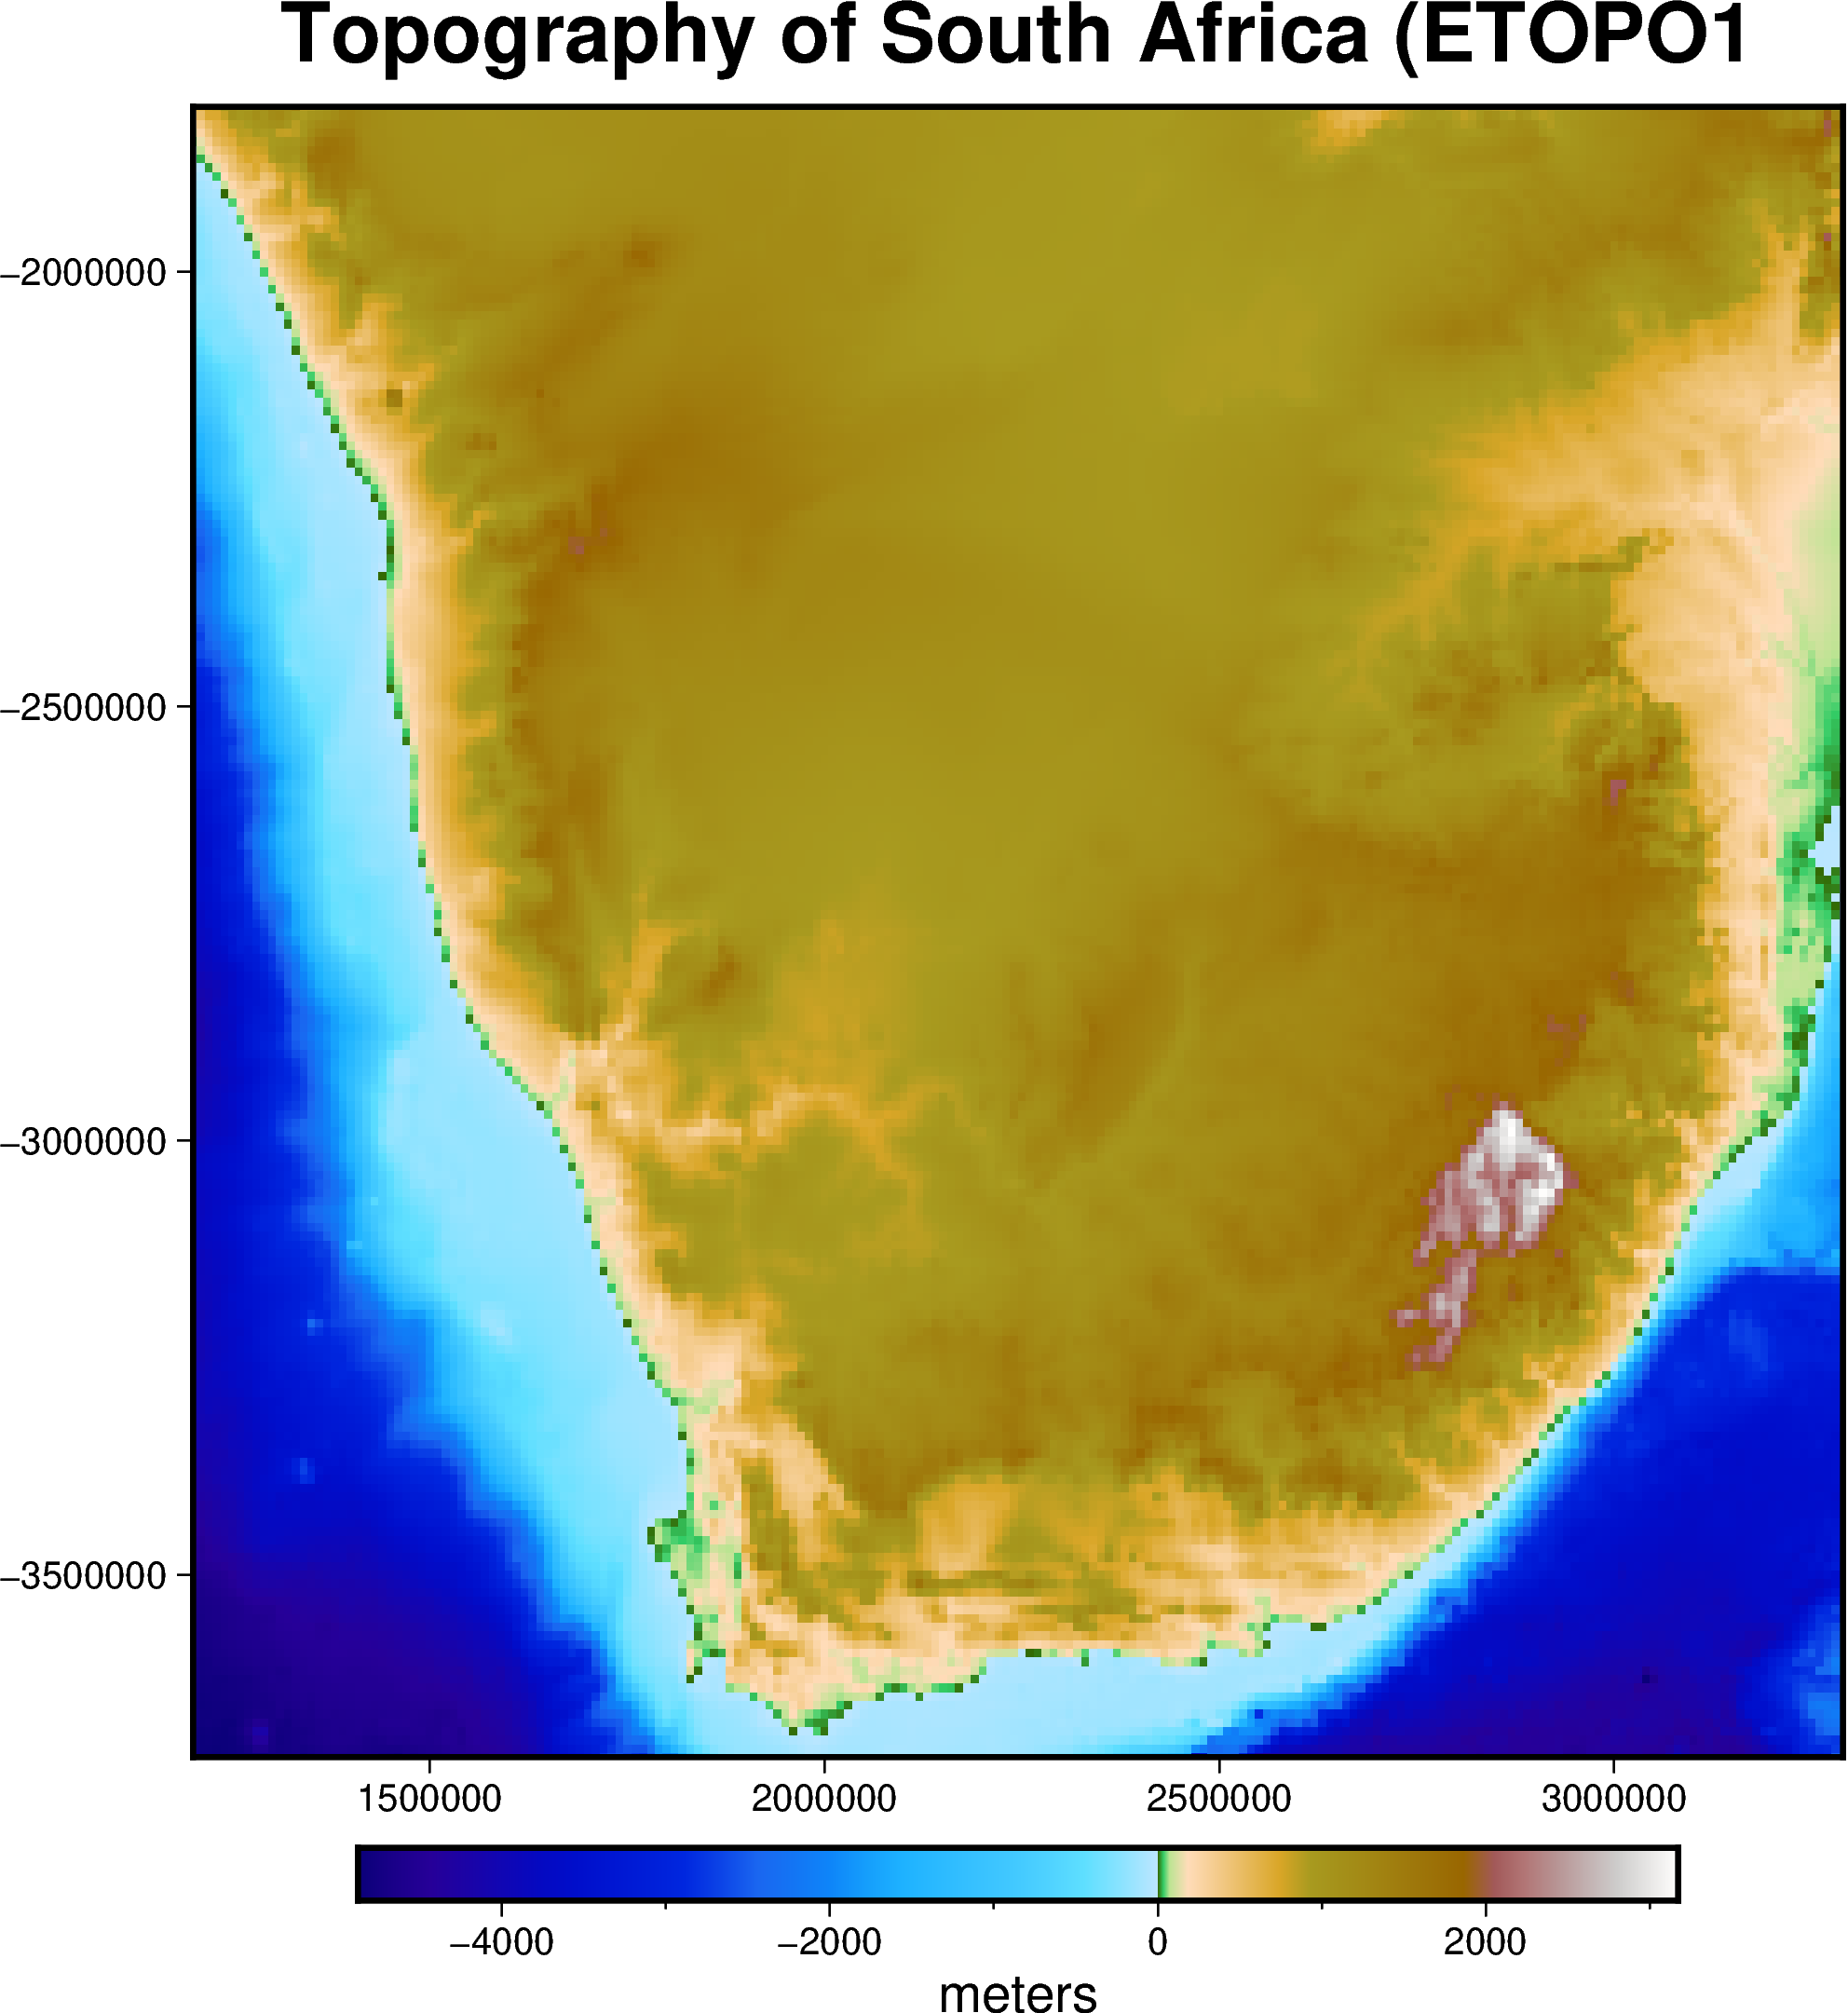

In [108]:
 # Make a plot using pygmt
fig = pygmt.Figure()
fig.grdimage(grid=xr_topo, region=region, cmap='etopo1', frame=['a','+tTopography of South Africa (ETOPO1'])#, projection='x1:80000000')
fig.colorbar(frame='+lmeters')
fig.show()

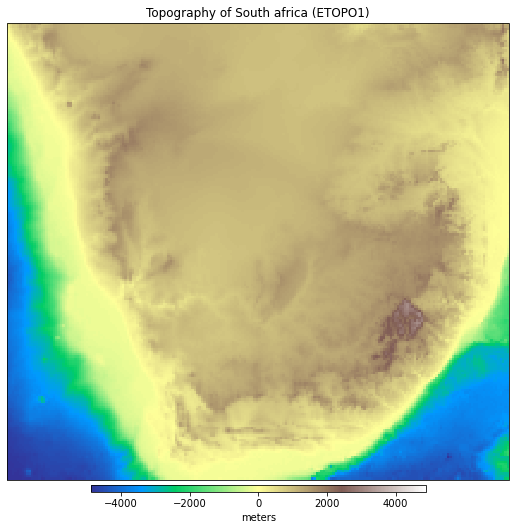

In [173]:
# convert to dataset
ds_topo=xr_topo.to_dataset()
# Make a plot using Cartopy
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())
pc = ds_topo.z.plot.pcolormesh(
    ax=ax, add_colorbar=False, cmap="terrain")
plt.colorbar(pc, label="meters", orientation="horizontal", aspect=50, pad=0.01, shrink=0.6)
ax.set_title("Topography of South africa (ETOPO1)")
plt.show()


# Calculate forward gravity of topography

One possible application of the harmonica.prism_layer function is to create a model of the terrain and compute its gravity effect. Here we will use a regular grid of topographic and bathymetric heights for South Africa to create a prisms layer that model the terrain with a density of 2670 kg/m^3 and the ocean with a density contrast of -1900 kg/m^3 obtained as the difference between the density of water (1000 kg/m^3) and the normal density of upper crust (2900 kg/m^3). Then we will use harmonica.prism_gravity to compute the gravity effect of the model on a regular grid of observation points.

In [138]:
ds_topo.z

<xarray.DataArray 'z' (y: 191, x: 210)>
array([[-4876.256  , -4859.7056 , -4867.2017 , ..., -2948.4338 ,
        -2490.6545 , -2390.4087 ],
       [-4875.2144 , -4856.1484 , -4850.12   , ..., -2871.849  ,
        -2728.0037 , -2643.0708 ],
       [-4877.663  , -4850.855  , -4832.301  , ..., -2730.1758 ,
        -2768.4167 , -2722.2742 ],
       ...,
       [  174.09033,   374.02637,   540.04956, ...,  2024.2081 ,
         1632.2793 ,  1393.9574 ],
       [  272.01562,   512.4415 ,   710.39935, ...,  1905.2152 ,
         1314.1034 ,  1262.26   ],
       [  397.15192,   599.15   ,   768.0344 , ...,  1728.8386 ,
         1097.8516 ,  1286.1328 ]], dtype=float32)
Coordinates:
  * x        (x) float64 1.2e+06 1.21e+06 1.22e+06 ... 3.28e+06 3.29e+06
  * y        (y) float64 -3.71e+06 -3.7e+06 -3.69e+06 ... -1.82e+06 -1.81e+06
Attributes:
    long_name:     z
    actual_range:  [-4877.66308594  3173.71240234]

In [165]:
# Create a 2d array with the density of the prisms Points above the geoid will
# have a density of 2670 kg/m^3 Points below the geoid will have a density
# contrast equal to the difference between the density of the ocean and the
# density of the upper crust: # 1000 kg/m^3 - 2900 kg/m^3
density = xr_topo.copy()  # copy topography to a new xr.DataArray
density.values[:] = 2670.0  # replace every value for the density of the topography
# Change density values of ocean points
density = density.where(xr_topo >= 0, 1000 - 2900)

# Create layer of prisms
prisms = hm.prism_layer(
    coordinates=(list(xr_topo.x), list(xr_topo.y)),
    surface=xr_topo,
    reference=0,
    properties={"density": density},
)


# Compute gravity field on a regular grid located at 4000m above the ellipsoid
# coordinates=vd.grid_coordinates(region=ris_300km_buffer,
#         spacing=grav_spacing, extra_coords=grav_elev)

# Compute gravity field on topography points
coordinates=df_topo.x, df_topo.y, df_topo.topography.where(df_topo.topography>0,0)

prisms_gravity = prisms.prism_layer.gravity(coordinates, field="g_z")

In [166]:
df_topo['g_z']=prisms_gravity
df_topo

,x,y,topography,g_z
0,1.196281e+06,-1.812870e+06,284.0,17.952376
1,1.206250e+06,-1.812870e+06,486.0,40.844558
2,1.216219e+06,-1.812870e+06,705.0,70.118208
3,1.226188e+06,-1.812870e+06,737.0,73.630839
4,1.236157e+06,-1.812870e+06,835.0,80.762796
...,...,...,...,...
35905,3.249897e+06,-3.706938e+06,-2908.0,-220.458176
35906,3.259866e+06,-3.706938e+06,-3043.0,-222.129024
35907,3.269835e+06,-3.706938e+06,-2982.0,-215.275080
35908,3.279804e+06,-3.706938e+06,-2484.0,-193.137241


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


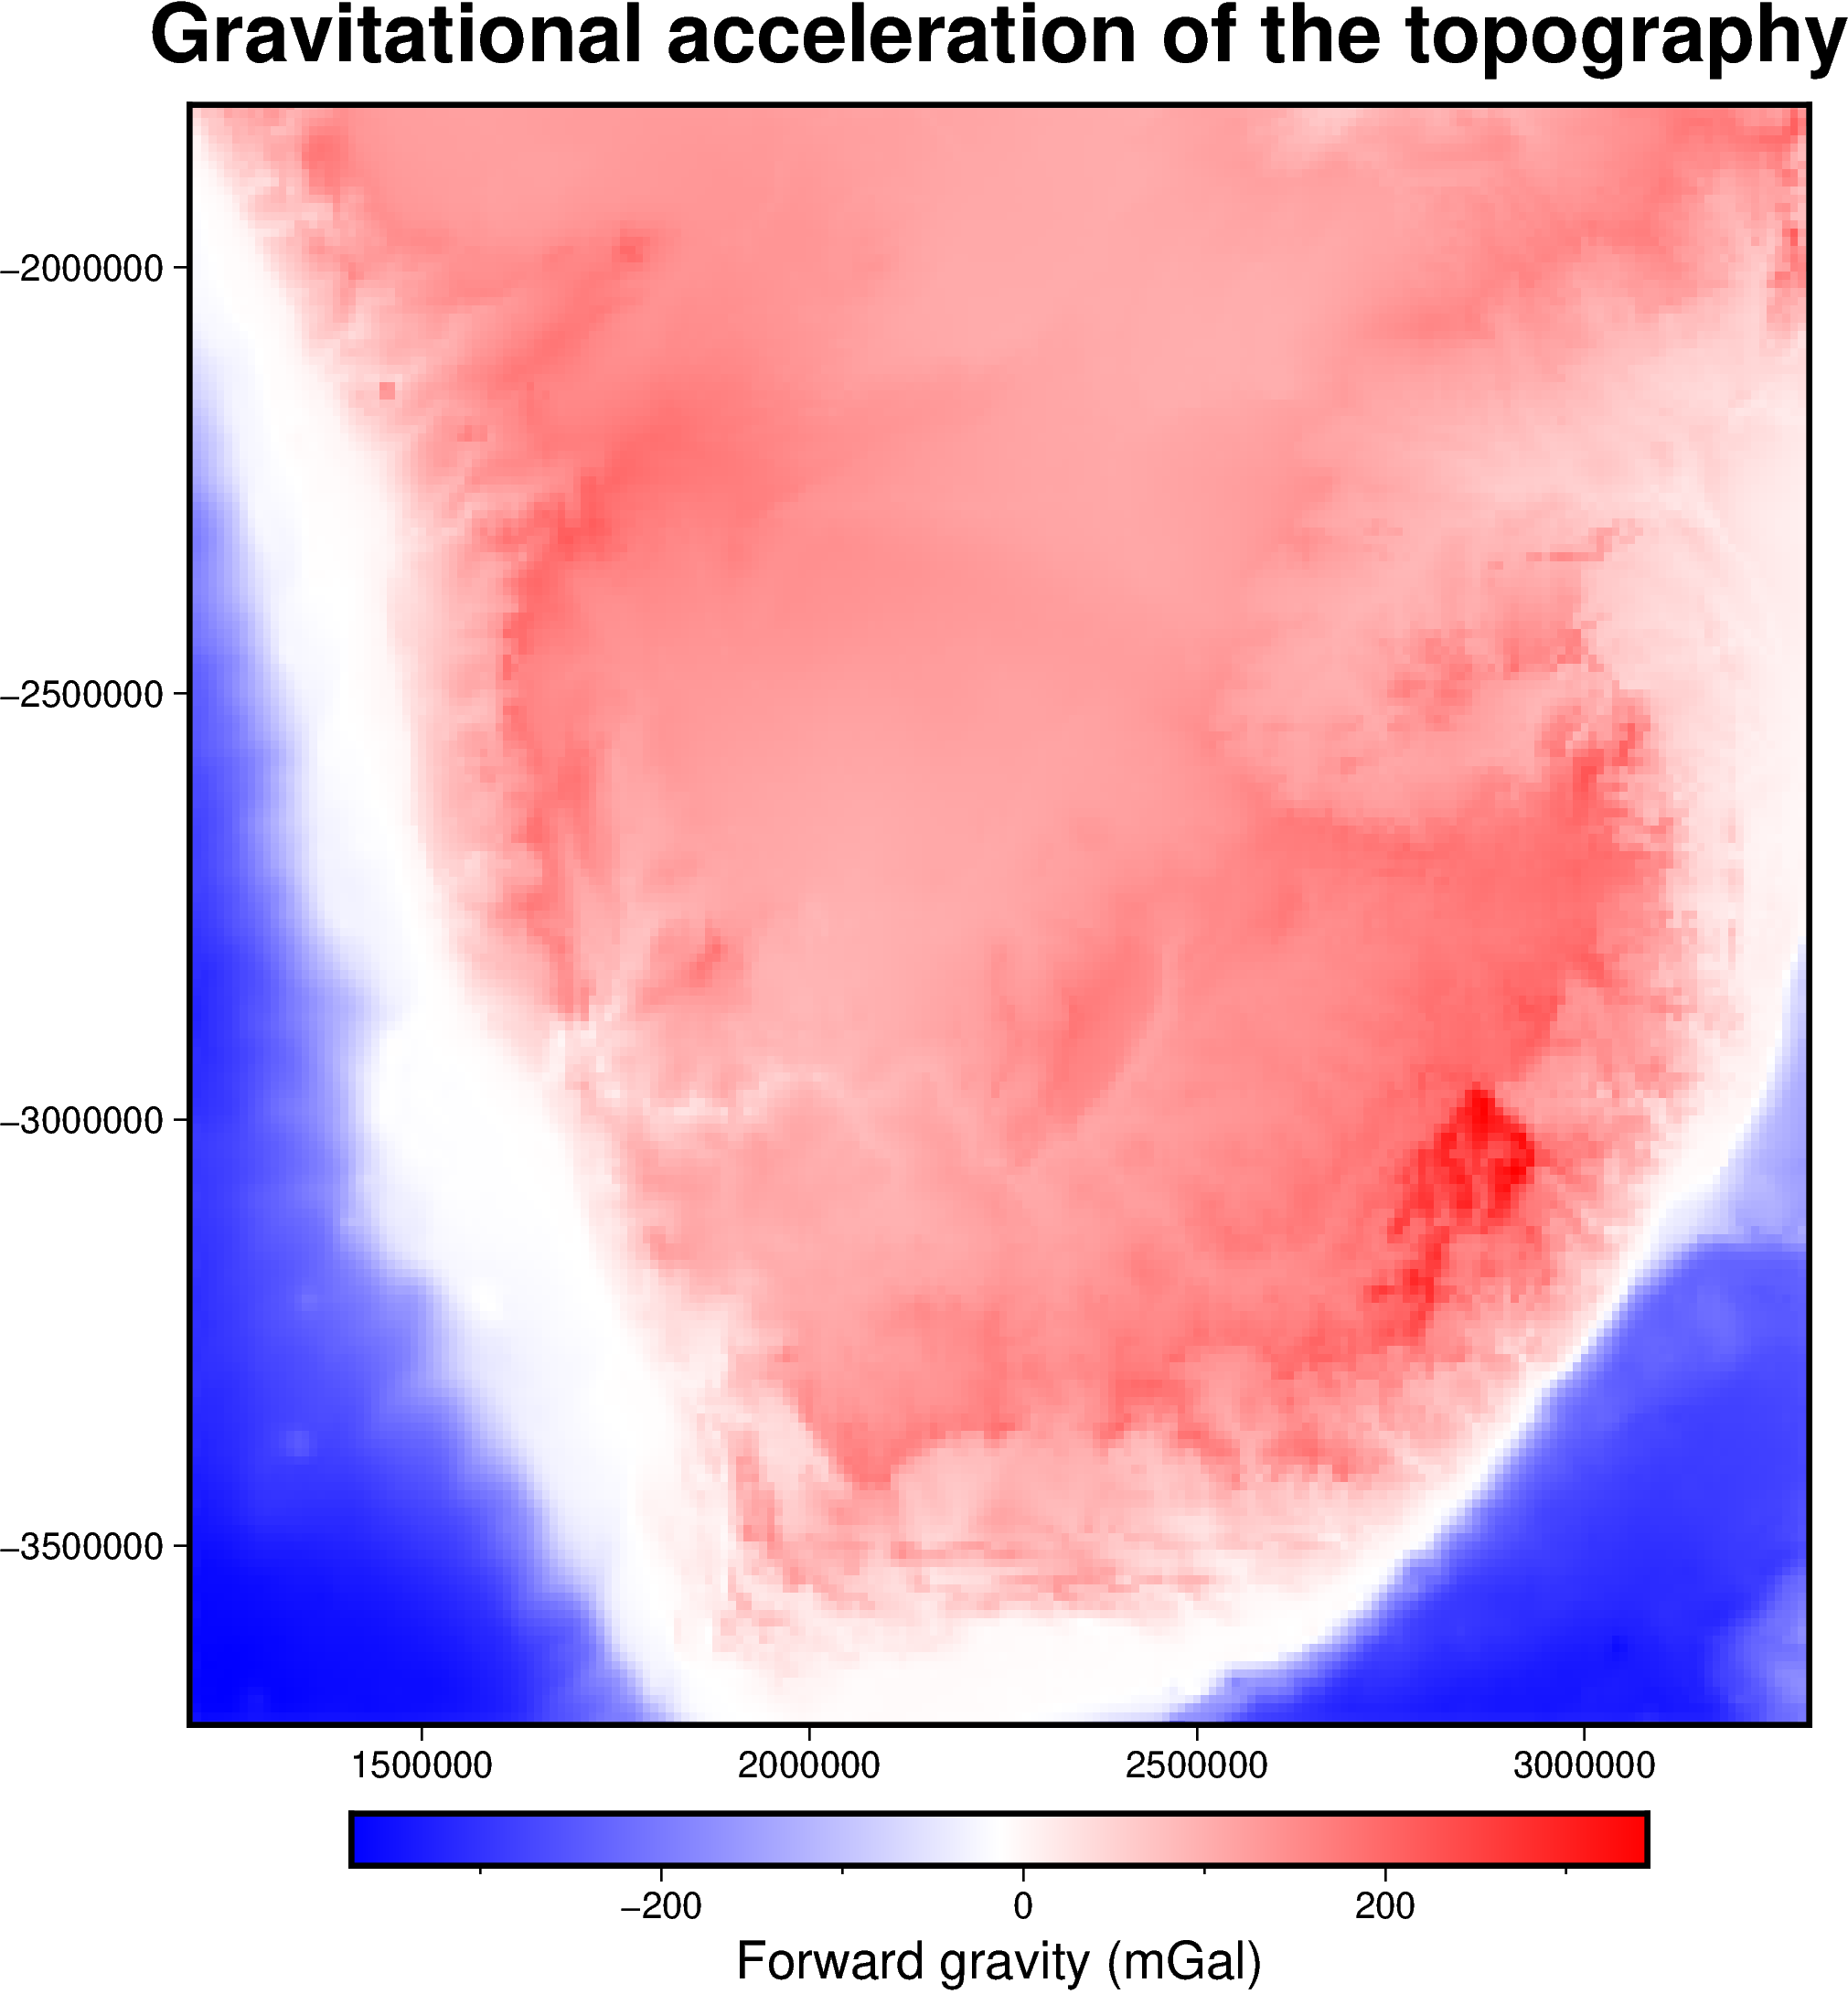

In [167]:
# Plot results with pygmt
da_prisms=pygmt.surface(data=df_topo[['x','y','g_z']], region=region, spacing=spacing, registration='g')

fig = pygmt.Figure()
fig.grdimage(grid=da_prisms, region=region, cmap='polar', frame=['a','+tGravitational acceleration of the topography'])
fig.colorbar(frame='+lForward gravity (mGal)')
fig.show()

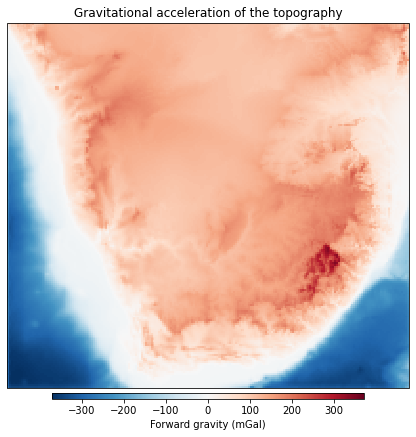

In [172]:
# convert to dataset
ds_prisms=da_prisms.to_dataset()

# Plot results with cartopy
# Make a plot of the computed gravity
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())
pc = ds_prisms.z.plot.pcolormesh(
    ax=ax, add_colorbar=False, cmap="RdBu_r")

plt.title("Gravitational acceleration of the topography")
plt.colorbar(
    pc, label="Forward gravity (mGal)", orientation="horizontal", shrink=0.7, pad=0.01, aspect=50)

plt.show()


# Plot gravity survey

In [3]:
# Read South Africa ground-based gravity
fname = ensaio.fetch_southern_africa_gravity(version=1)
df_grav = pd.read_csv(fname)

# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=df_grav.latitude.mean())
df_grav['x'], df_grav['y'] = projection(df_grav.longitude, df_grav.latitude)

df_grav

,longitude,latitude,height_sea_level_m,gravity_mgal,x,y
0,18.34444,-34.12971,32.2,979656.12,1.808067e+06,-3.561303e+06
1,18.36028,-34.08833,592.5,979508.21,1.809629e+06,-3.556400e+06
2,18.37418,-34.19583,18.4,979666.46,1.810999e+06,-3.569143e+06
3,18.40388,-34.23972,25.0,979671.03,1.813926e+06,-3.574351e+06
4,18.41112,-34.16444,228.7,979616.11,1.814640e+06,-3.565421e+06
...,...,...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09,2.091982e+06,-1.788067e+06
14355,21.27500,-17.98333,1033.3,978183.09,2.096910e+06,-1.790641e+06
14356,21.70833,-17.99166,1041.8,978182.69,2.139620e+06,-1.791499e+06
14357,21.85000,-17.95833,1033.3,978193.18,2.153583e+06,-1.788067e+06


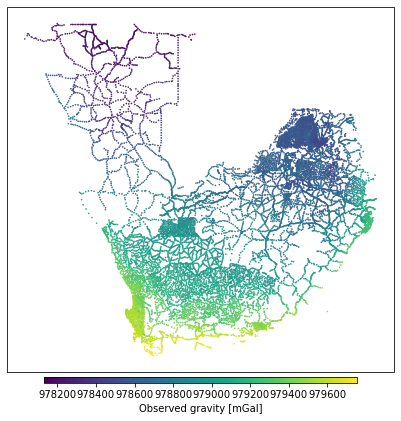

In [5]:
# Plot observed gravity stations
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())

tmp = ax.scatter(
    df_grav.x,
    df_grav.y,
    c=df_grav.gravity_mgal,
    s=0.4,
    cmap="viridis")

plt.colorbar(
    tmp, label="Observed gravity [mGal]", orientation="horizontal", shrink=0.7, pad=0.01, aspect=50)
plt.show()

In [ ]:
# Plot gravity stations ontop of forward gravity
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Mercator())
pc = ds_prisms.z.plot.pcolormesh(
    ax=ax, add_colorbar=False, cmap="RdBu_r")

plt.title("Gravitational acceleration of the topography")
plt.colorbar(
    pc, label="Forward gravity (mGal)", orientation="horizontal", shrink=0.7, pad=0.01, aspect=50)

tmp = ax.scatter(
    df_grav.x,
    df_grav.y,
    c=df_grav.gravity_mgal,
    s=0.2,
    cmap="RdBu_r")

plt.colorbar(
    tmp, label="Observed gravity [mGal]", orientation="horizontal", shrink=0.7, pad=0.01, aspect=50)

plt.show()

In [199]:
df_grav.gravity_mgal.describe()

count     14359.000000
mean     978882.790848
std         343.972892
min      978131.300000
25%      978605.080000
50%      978846.030000
75%      979118.350000
max      979754.200000
Name: gravity_mgal, dtype: float64

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


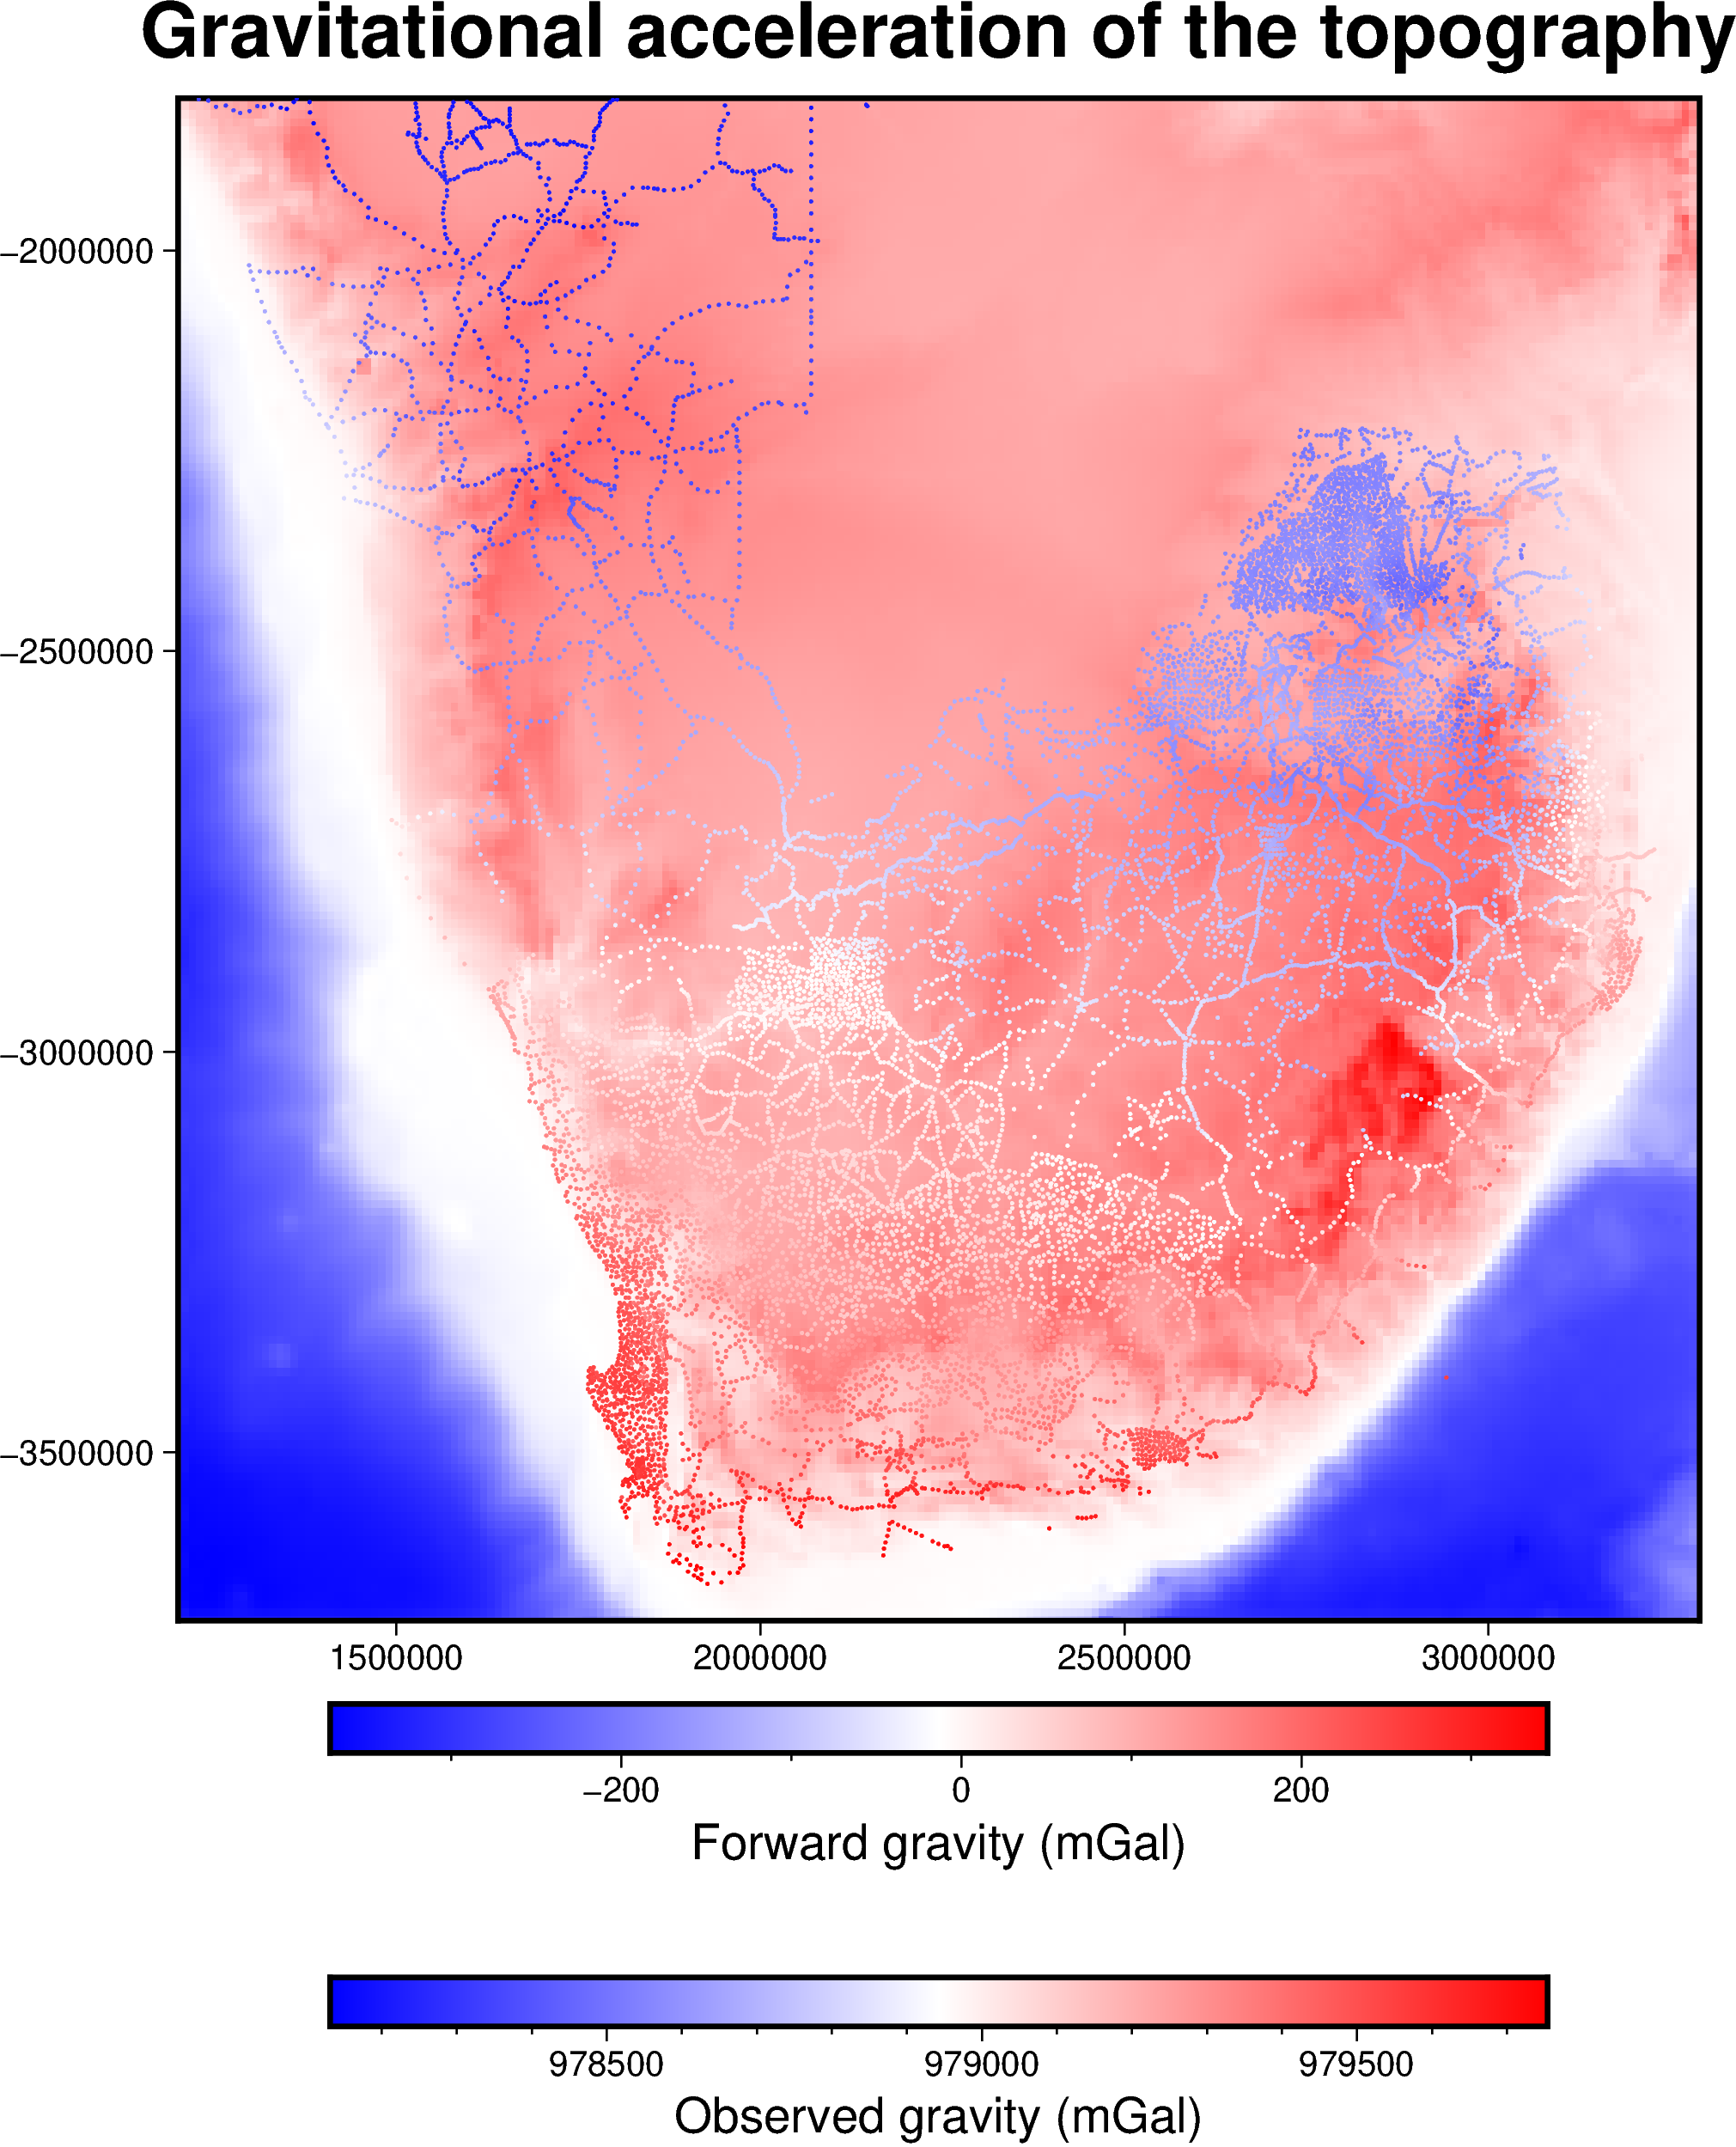

In [210]:
# plot with pygmt

fig = pygmt.Figure()
fig.grdimage(grid=da_prisms, region=region, cmap='polar', frame=['a','+tGravitational acceleration of the topography'])
fig.colorbar(frame='+lForward gravity (mGal)')

pygmt.makecpt(cmap='polar', series=(df_grav.gravity_mgal.min(),df_grav.gravity_mgal.max()))
fig.plot(x=df_grav.x, y=df_grav.y, 
         color=df_grav.gravity_mgal, 
         style="c0.04c",
         cmap=True)
fig.colorbar(cmap=True,frame='+lObserved gravity (mGal)', position="jBC+h+m+o0c/-4c")

fig.show()


# Grid the gravity data
### use block-averaged equivalent sources

In [14]:
# Create the equivalent sources.
# We'll use block-averaged sources at a constant depth beneath the observation
# points. We will interpolate on a grid with a resolution of 5000m, so we will
# use blocks of the same size. The damping parameter helps smooth the predicted
# data and ensure stability.
eqs = hm.EquivalentSources(depth=1000, damping=1)#, block_size=5000, depth_type="constant")
# Fit the sources coefficients to the observed gravity anomaly.
eqs.fit((df_grav.x, df_grav.y, df_grav.height_sea_level_m), df_grav.gravity_mgal)
# Interpolate data on a regular grid with 5000 m spacing. The interpolation
# requires the height of the grid points (upward coordinate). By passing in
# 1000 m, we're effectively upward-continuing the data.
grid = eqs.grid(upward=1500, spacing=5000, data_names=["grav"])


C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


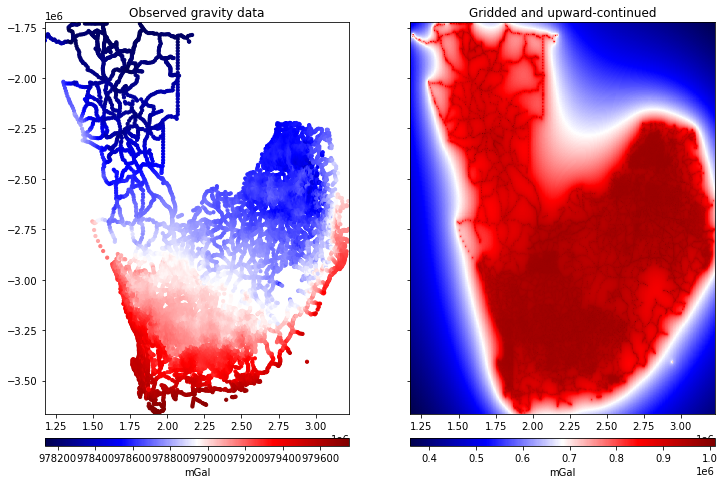

In [15]:
# Plot original magnetic anomaly and the gridded and upward-continued version
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
# maxabs = vd.maxabs(df_grav.gravity_mgal, grid.grav.values)

ax1.set_title("Observed gravity data")
tmp = ax1.scatter(
    df_grav.x,
    df_grav.y,
    c=df_grav.gravity_mgal,
    s=10,
    # vmin=-maxabs,
    # vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax1, label="mGal", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(df_grav.x.min(), df_grav.x.max())
ax1.set_ylim(df_grav.y.min(), df_grav.y.max())

ax2.set_title("Gridded and upward-continued")

tmp = grid.grav.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    # vmin=-maxabs,
    # vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax2, label="mGal", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(df_grav.x.min(), df_grav.x.max())
ax2.set_ylim(df_grav.y.min(), df_grav.y.max())

plt.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


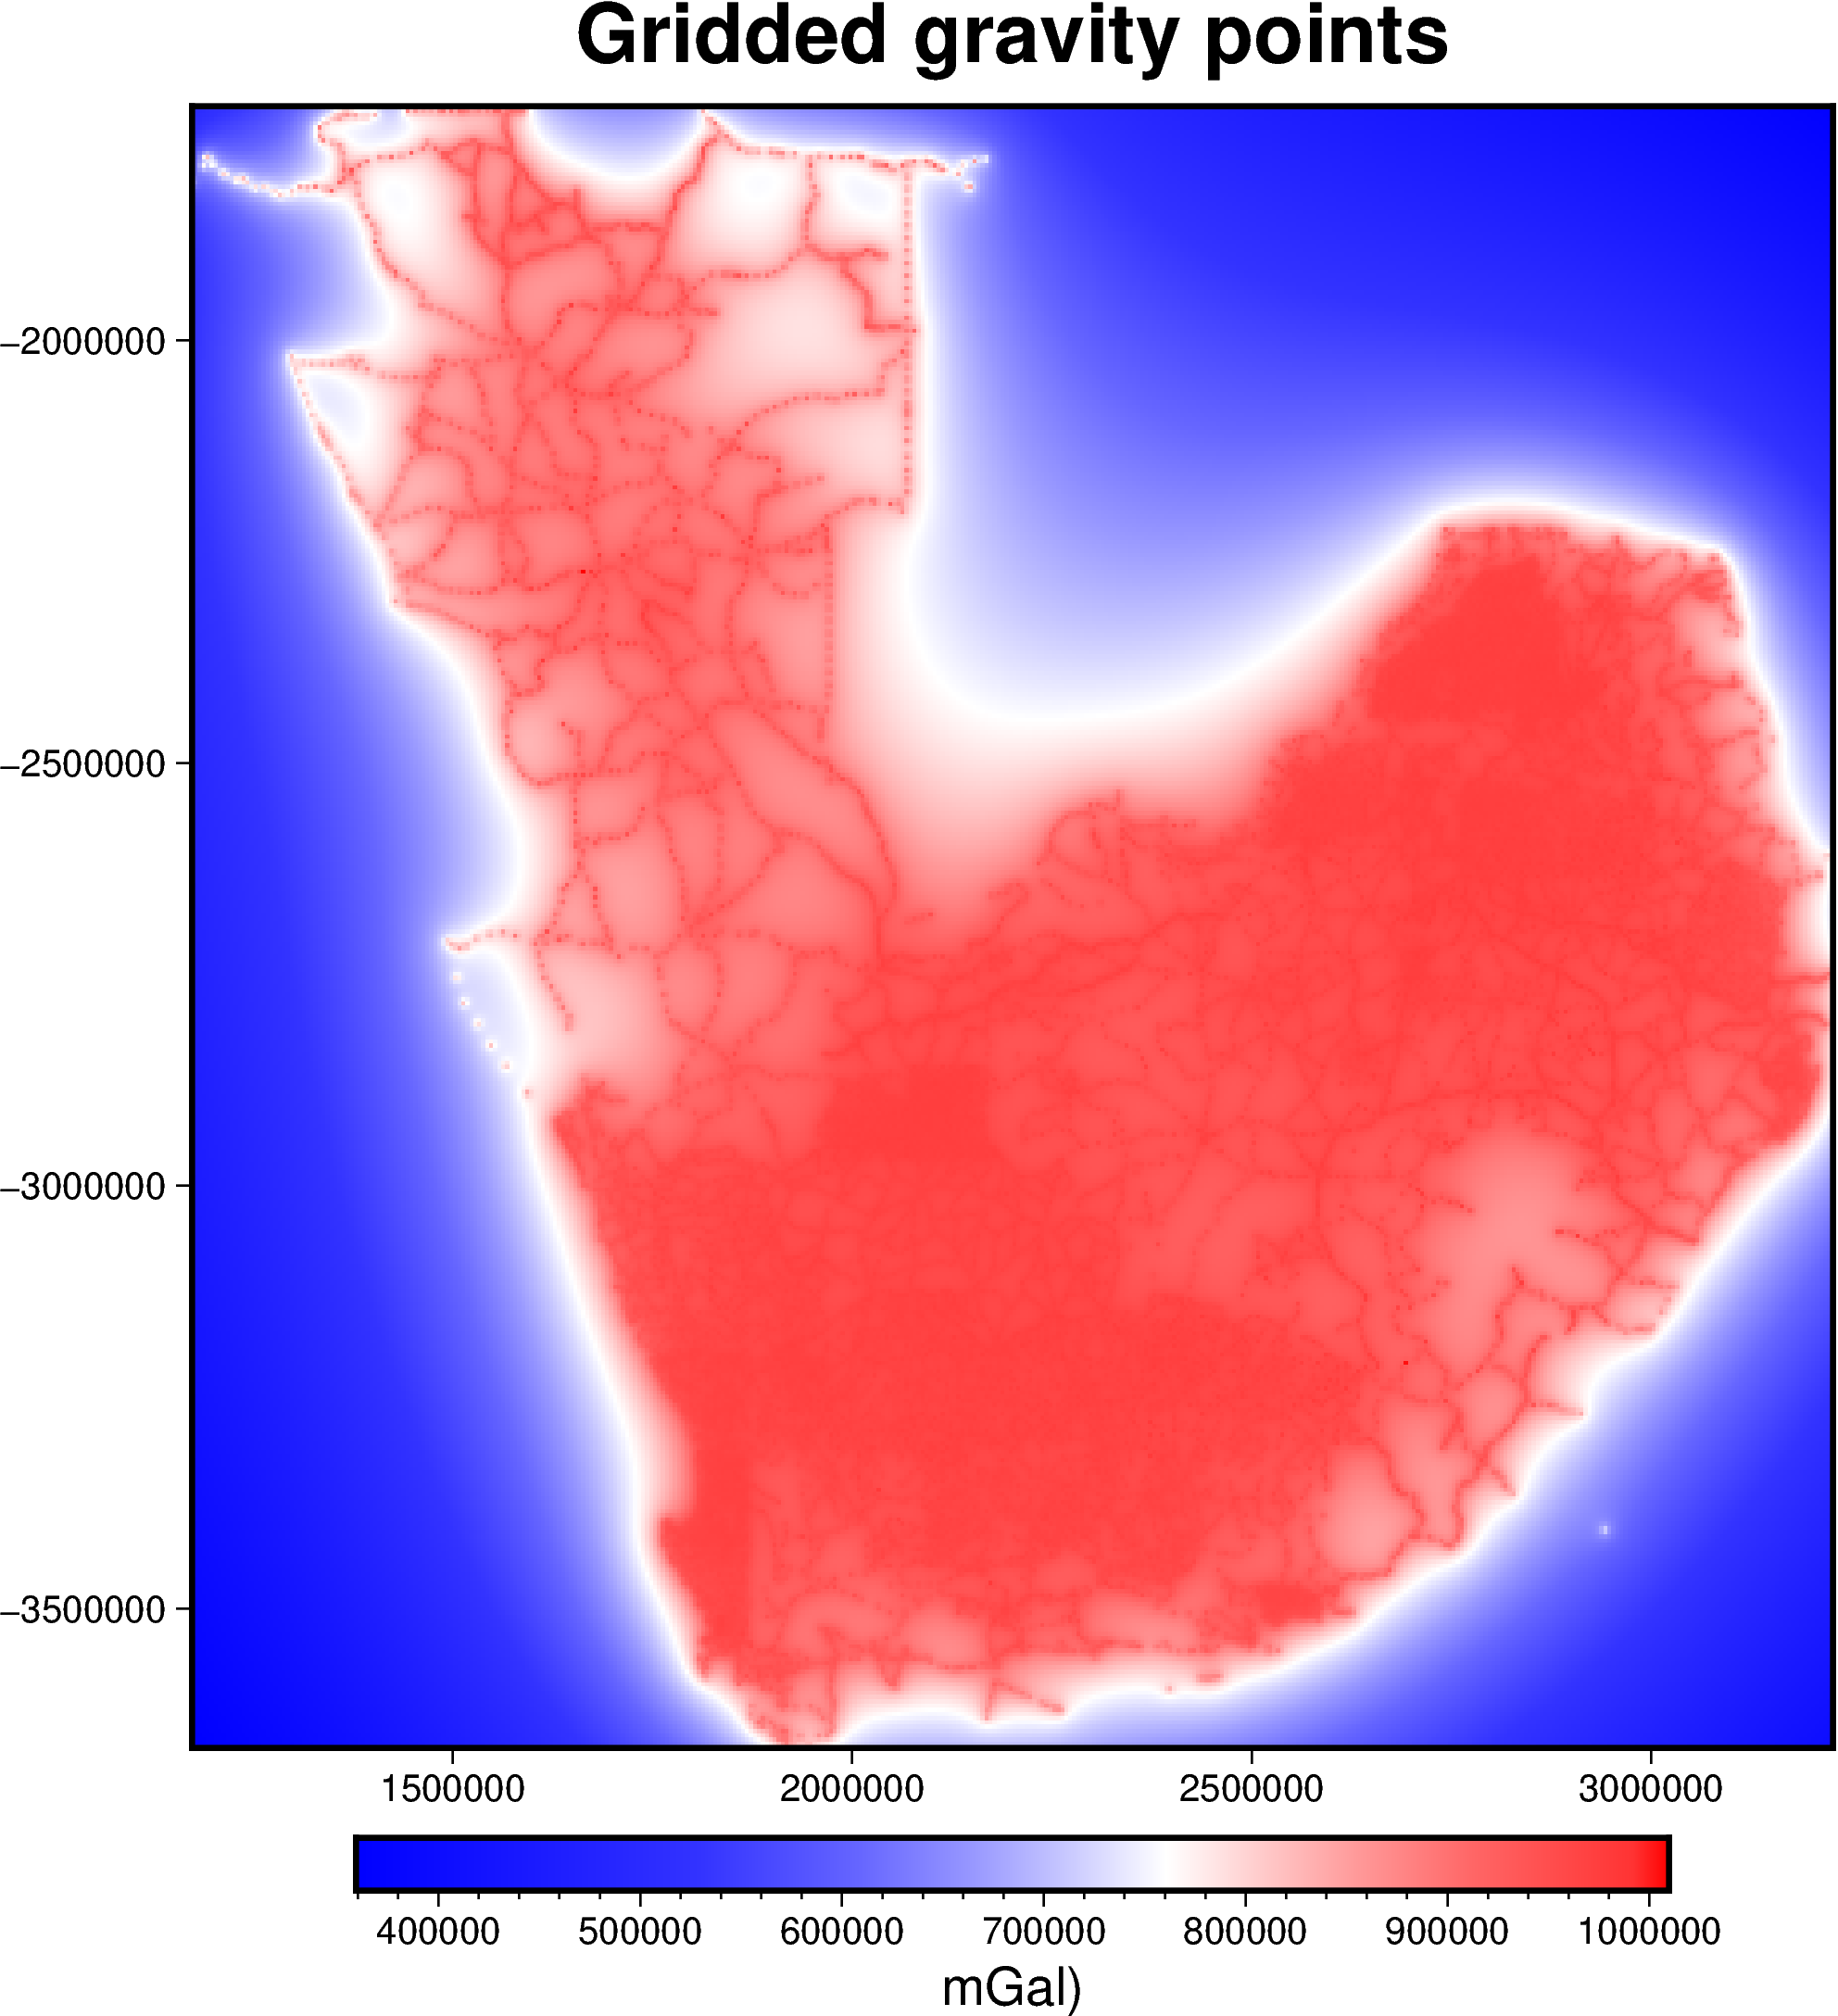

In [25]:
# plot with pygmt

fig = pygmt.Figure()
pygmt.grd2cpt(grid=grid.grav, continuous=True, cmap='polar')
fig.grdimage(grid=grid.grav, region=region, cmap=True, frame=['a','+tGridded gravity points'])
fig.colorbar(frame='+lmGal)')

fig.show()

### With Verde scipy gridder

Gridder used: ScipyGridder()
Data region: (1173710.5665739446, 3227582.0874219984, -3664516.677160123, -1723816.5591087798)
Generated geographic grid:
<xarray.Dataset>
Dimensions:       (x: 389, y: 412)
Coordinates:
  * y             (y) float64 1.174e+06 1.179e+06 ... 3.223e+06 3.228e+06
  * x             (x) float64 -3.665e+06 -3.66e+06 ... -1.729e+06 -1.724e+06
Data variables:
    gravity_mgal  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder()


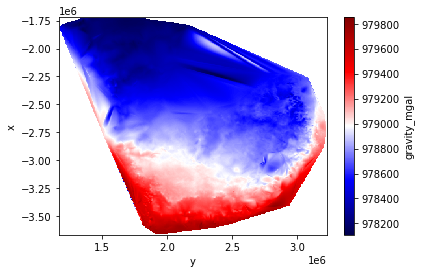

In [26]:
spacing = 5000
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, grav = reducer.filter((df_grav.x, df_grav.y), df_grav.gravity_mgal)

grd = vd.ScipyGridder(method='cubic').fit(coordinates, grav)
print('Gridder used:', grd)

# Get the grid region in geographic coordinates
region = vd.get_region((df_grav.x, df_grav.y))
print("Data region:", region)

grid = grd.grid(
    region=region,
    spacing=spacing,
    dims=["x", "y"],
    data_names="gravity_mgal",
)
print("Generated geographic grid:")
print(grid)

plt.figure()
grid.gravity_mgal.plot.pcolormesh( cmap="seismic",)
plt.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


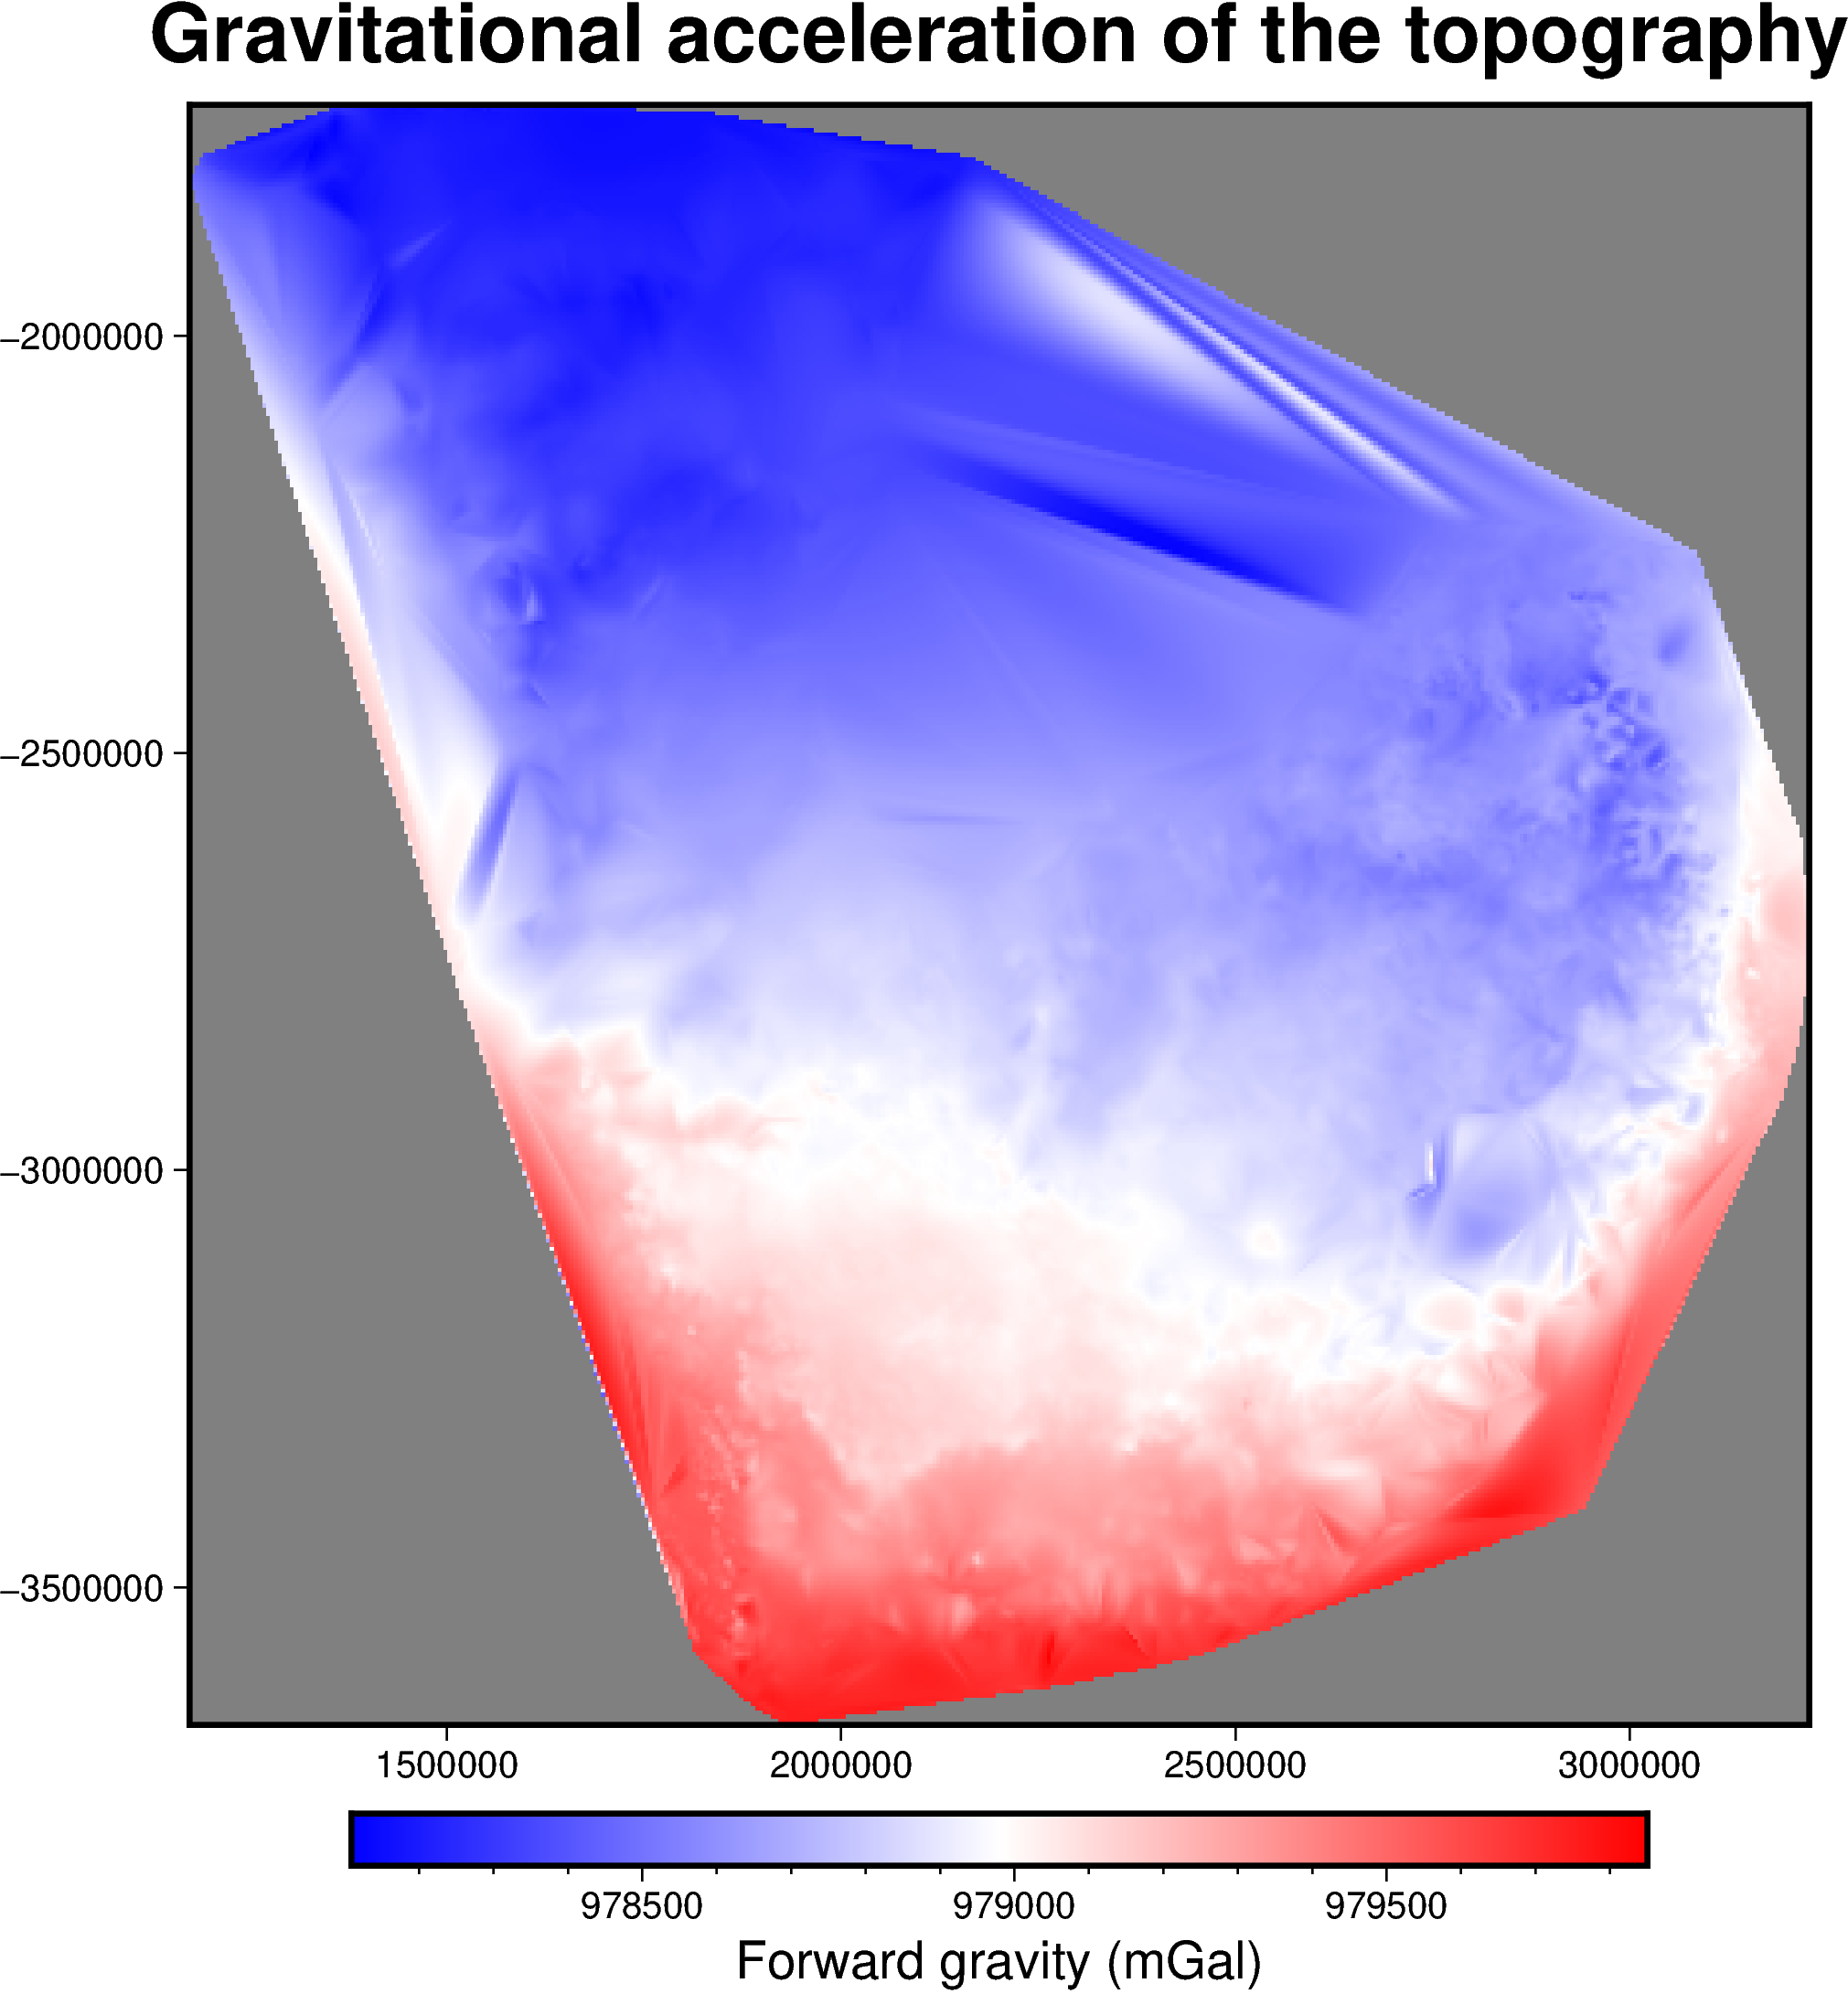

In [11]:
# plot with pygmt

fig = pygmt.Figure()
fig.grdimage(grid=grid.gravity_mgal, region=region, cmap='polar', frame=['a','+tGravitational acceleration of the topography'])
fig.colorbar(frame='+lForward gravity (mGal)')

fig.show()

### with pygmt surface

surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


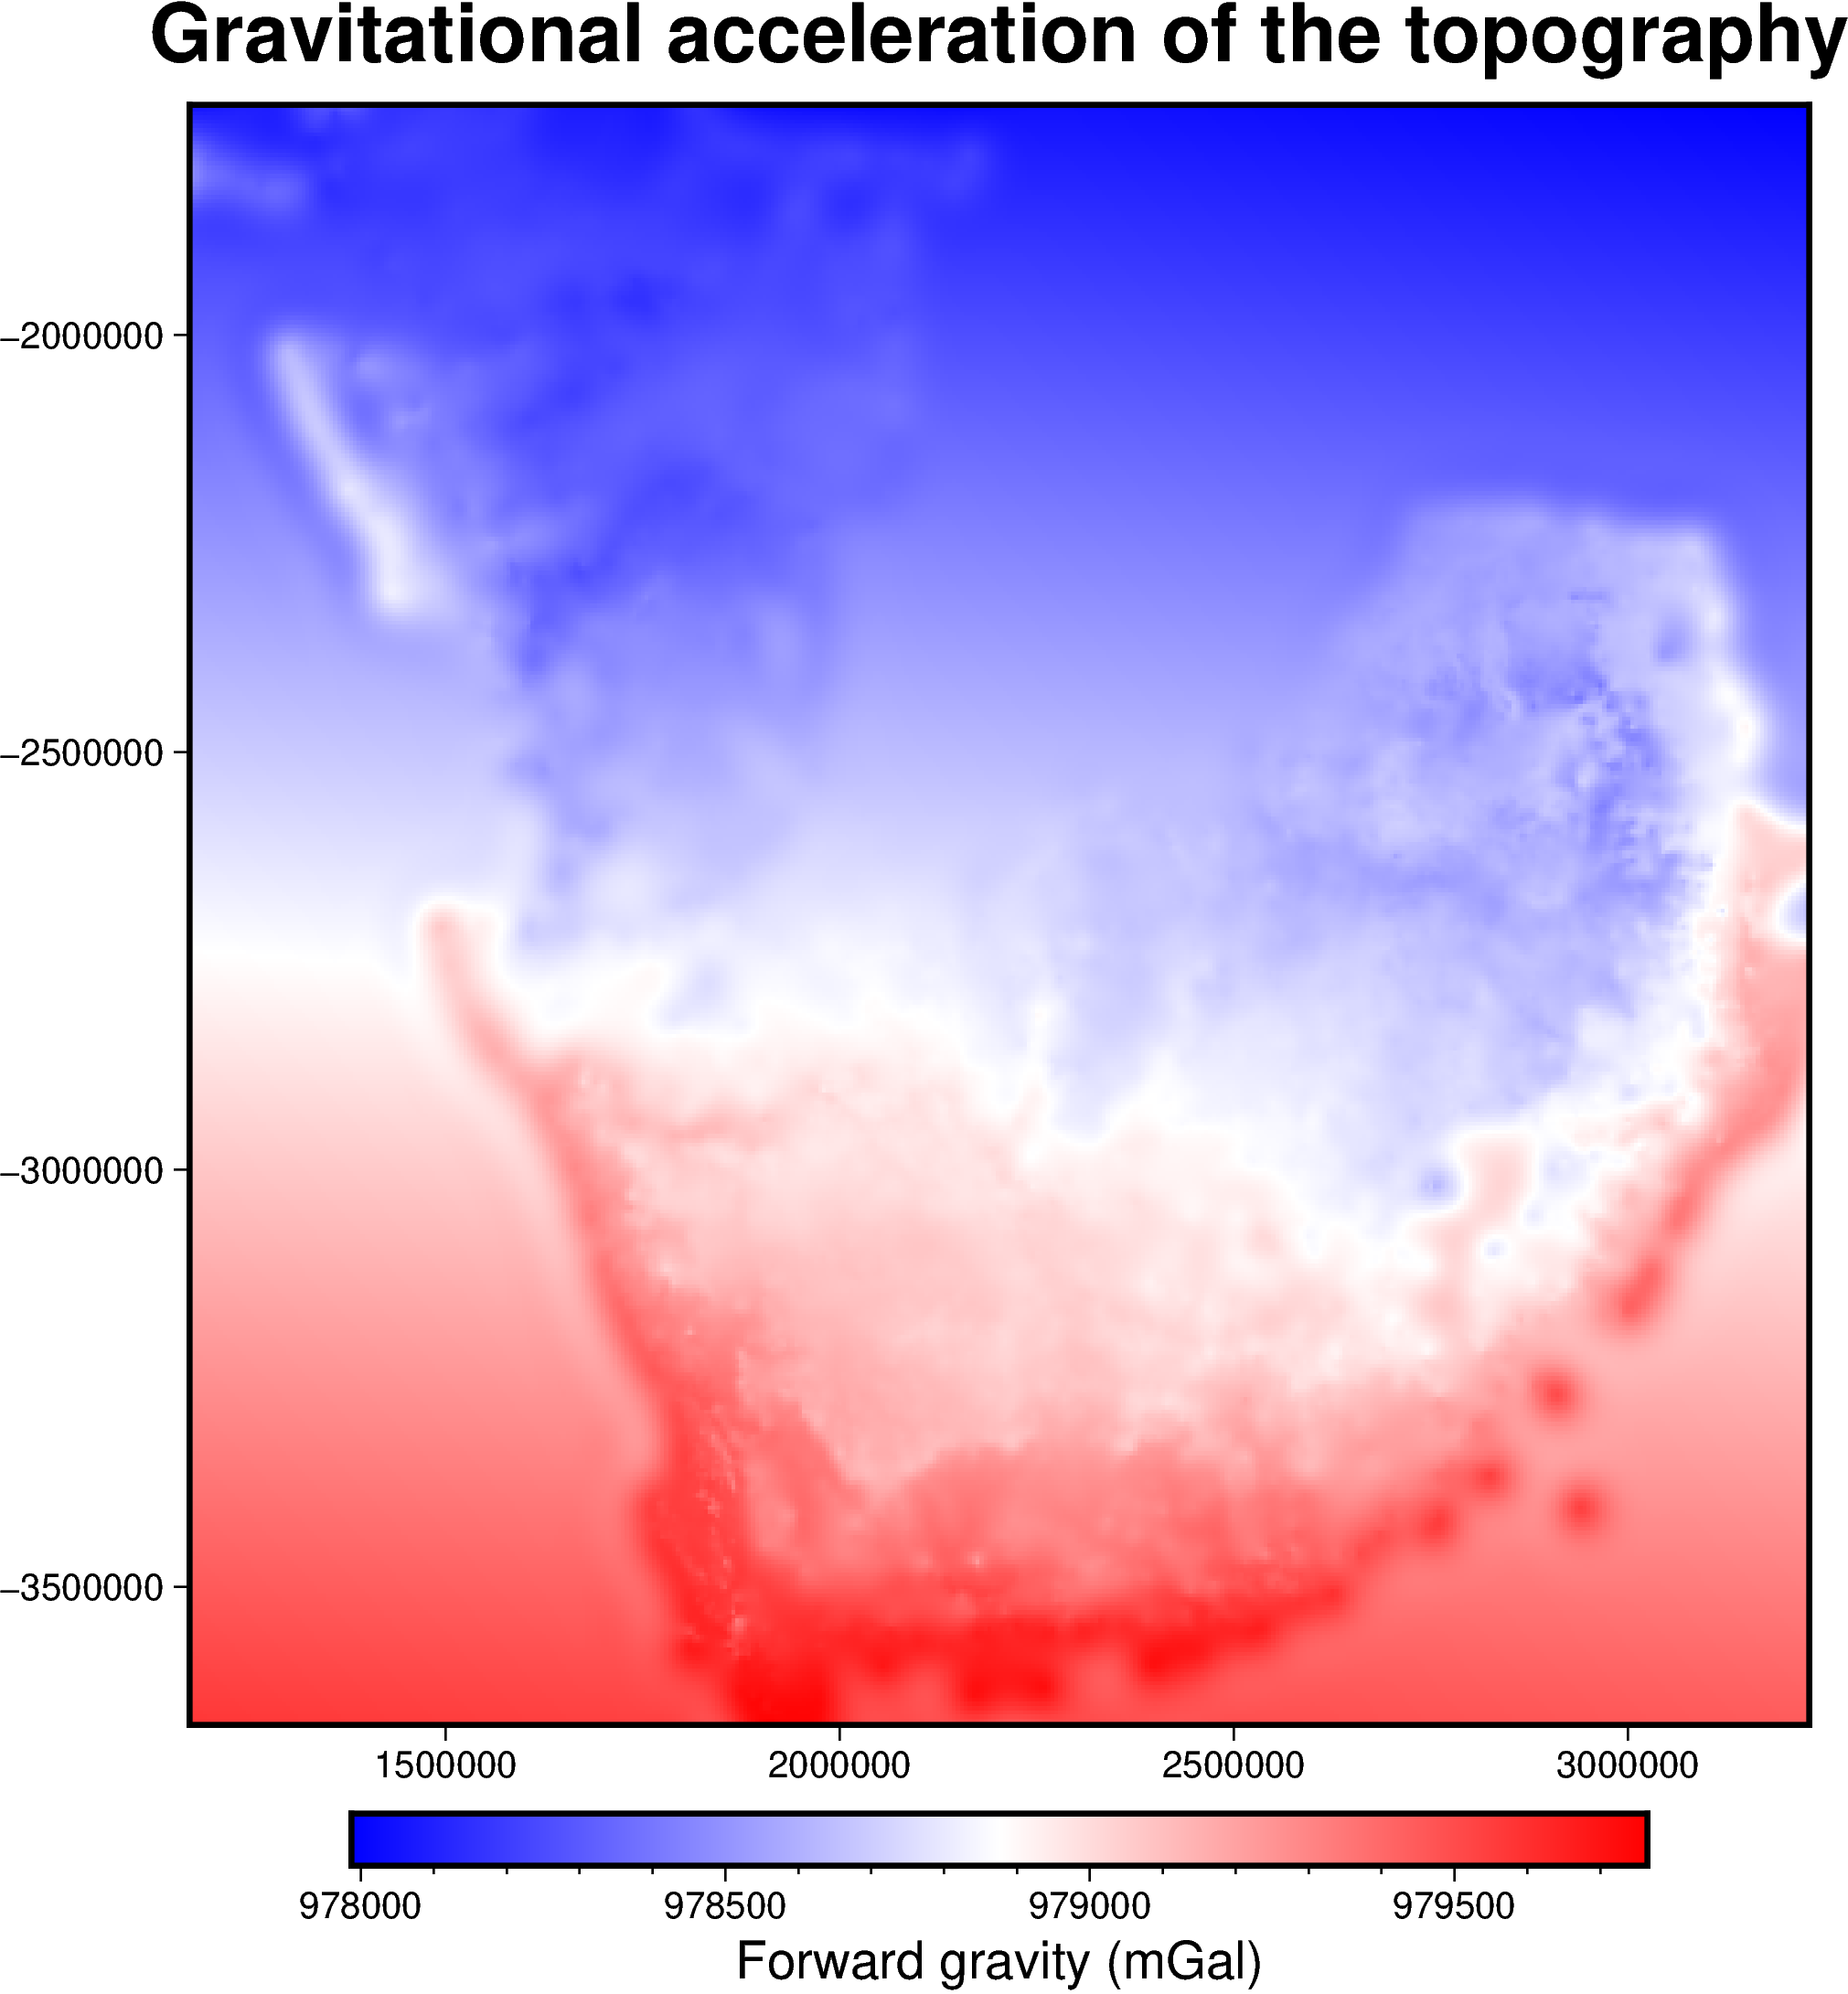

In [27]:
spacing=5000
x_min = round(df_grav.x.min()/spacing)*spacing
x_max = round(df_grav.x.max()/spacing)*spacing
y_min = round(df_grav.y.min()/spacing)*spacing
y_max = round(df_grav.y.max()/spacing)*spacing
region=x_min, x_max, y_min, y_max

# grid data
df_grav=pygmt.blockmedian(data=df_grav[['x', 'y', 'gravity_mgal']], region=region, spacing=spacing)
da_grav=pygmt.surface(data=df_grav, region=region, spacing=spacing, registration='g')

# plot with pygmt
fig = pygmt.Figure()
fig.grdimage(grid=da_grav, region=region, cmap='polar', frame=['a','+tGravitational acceleration of the topography'])
fig.colorbar(frame='+lForward gravity (mGal)')

# pygmt.makecpt(cmap='polar', series=(df_grav.gravity_mgal.min(),df_grav.gravity_mgal.max()))
# fig.plot(x=df_grav.x, y=df_grav.y, 
#          color=df_grav.gravity_mgal, 
#          style="c0.04c",
#          cmap=True)
# fig.colorbar(cmap=True,frame='+lObserved gravity (mGal)', position="jBC+h+m+o0c/-4c")

fig.show()

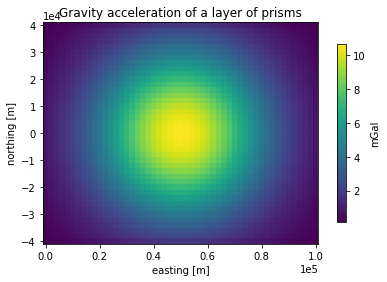

In [3]:
# Create a layer of prisms
region = (0, 100e3, -40e3, 40e3)
spacing = 2e3
(easting, northing) = vd.grid_coordinates(region=region, spacing=spacing)
surface = 100 * np.exp(-((easting - 50e3) ** 2 + northing ** 2) / 1e9)
density = 2670.0 * np.ones_like(surface)
prisms = hm.prism_layer(
    coordinates=(easting[0, :], northing[:, 0]),
    surface=surface,
    reference=0,
    properties={"density": density},
)

# Compute gravity field of prisms on a regular grid of observation points
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=1e3)
gravity = prisms.prism_layer.gravity(coordinates, field="g_z")

# Plot gravity field
plt.pcolormesh(*coordinates[:2], gravity)
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Gravity acceleration of a layer of prisms")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()